In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


from  utils.preprocessing_utils import parse_data,build_dataframe_from_json,get_rows_containing_label,get_most_frequent_words
import utils.plot_utils as pltUtils
from sklearn.preprocessing import MultiLabelBinarizer,MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from utils.source_code_feature_extractor import SourceCodeFeatureExtractor
from scipy.sparse import hstack, csr_matrix
from utils.training_config import TrainingConfig
from utils.training_utils import analyze_tag_confusions,multilabel_stratified_split,multilabel_oversample,bar_plot_confusion
from collections import Counter
from nltk.corpus import stopwords
from lightgbm import LGBMClassifier



# Data loading into a dataframe

In [3]:
jsonList = parse_data("C:\\Users\\francois.le-guernic\\Desktop\\CodeClassification\\code_classification_dataset")


100%|██████████| 4982/4982 [00:00<00:00, 11260.22it/s]


In [4]:
config = TrainingConfig(tags=['math', 'graphs', 'strings', 'number theory', 'trees', 'geometry', 'games', 'probabilities'])
dataframe = build_dataframe_from_json(jsonList,config)

# Data analysis

c:\Users\francois.le-guernic\Desktop\CodeClassification\utils\plot_utils.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tagNames,rotation=45,ha="right")


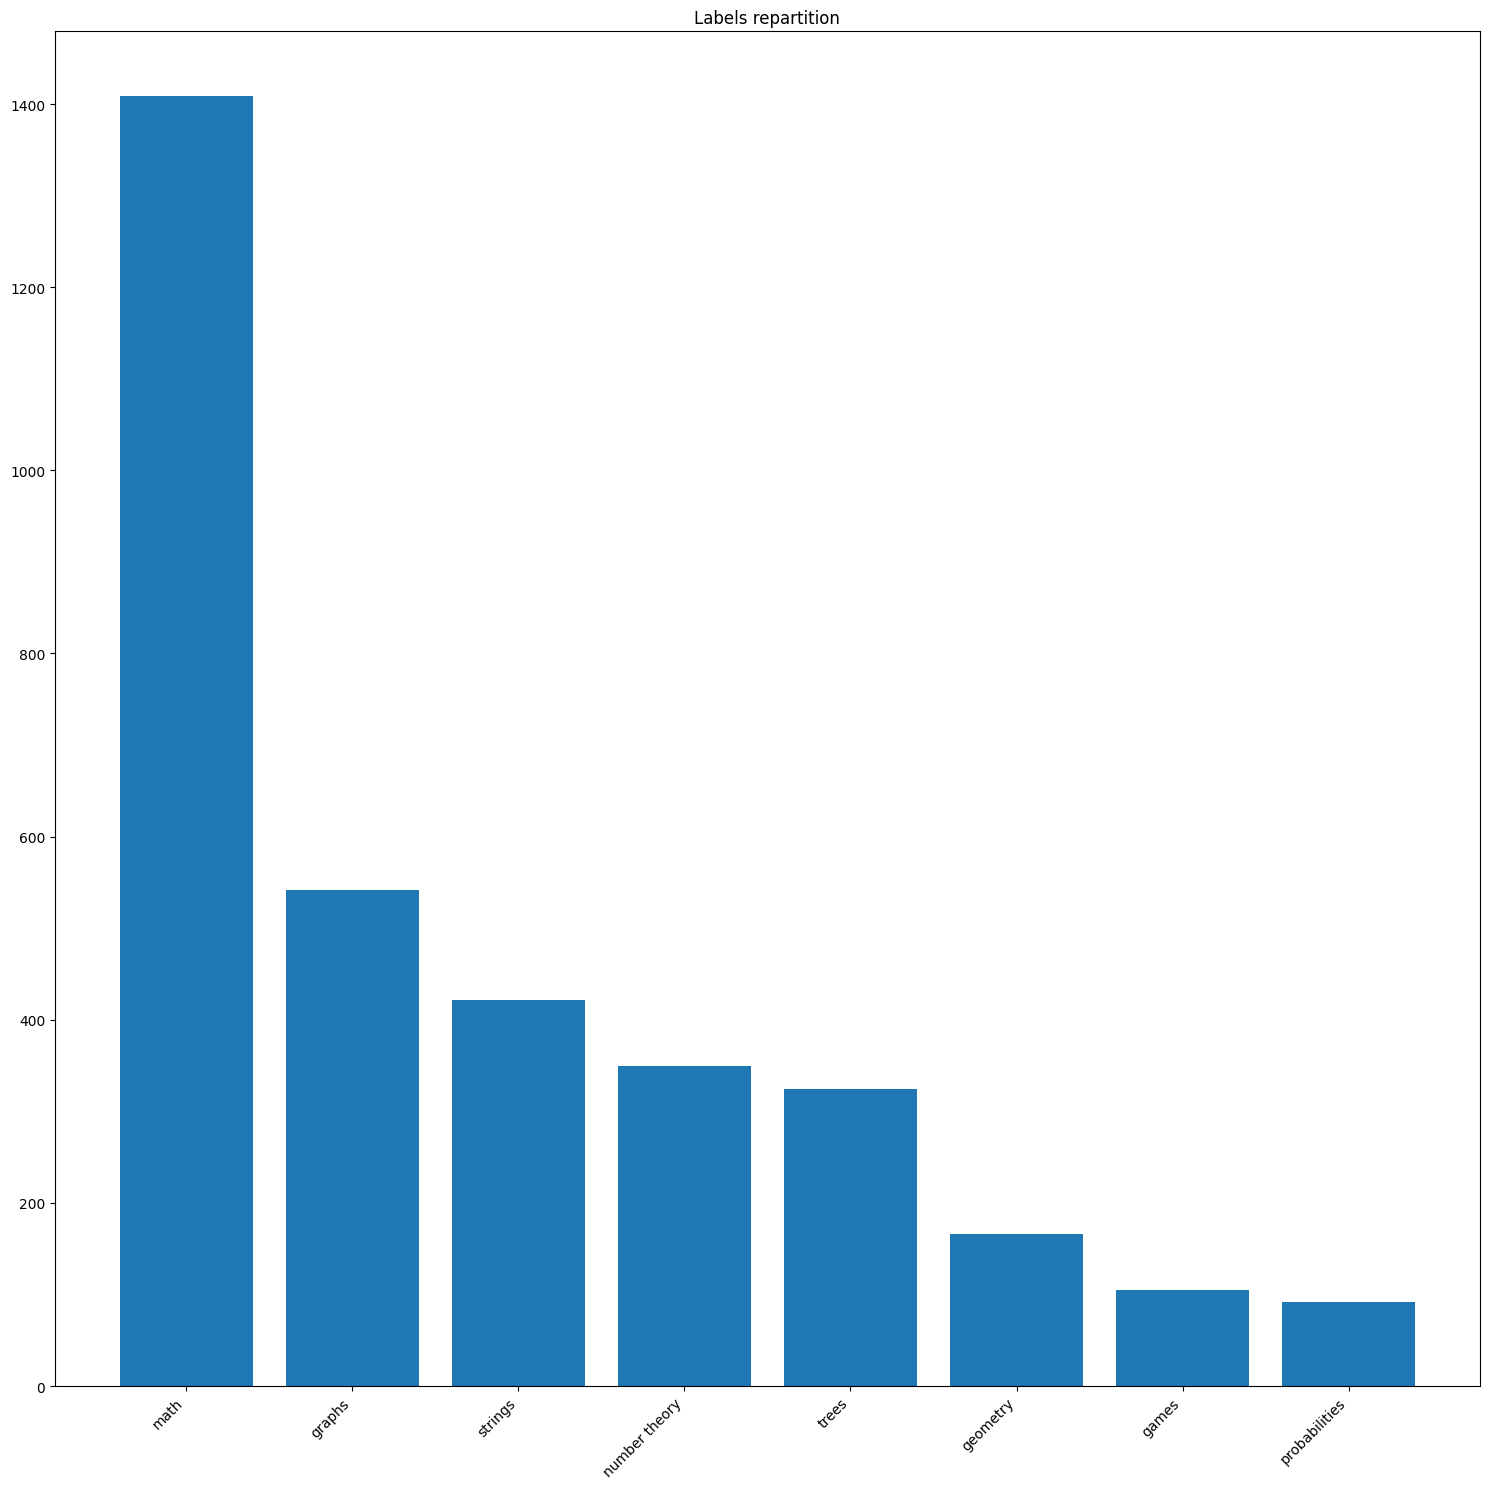

In [4]:

pltUtils.plot_tags_names_repartition(dataframe["tags"])
probability_count = sum("probabilities" in tags for tags in dataframe["tags"])

In [ ]:
import nltk
nltk.download('names')
from nltk.corpus import names

name_list = set(name.lower() for name in names.words())

def remove_first_names(text):
    words = text.split()
    return " ".join(word for word in words if word.lower() not in name_list)

config = TrainingConfig(tags=['math', 'graphs', 'strings', 'number theory', 'trees', 'geometry', 'games', 'probabilities'])
dataframe = build_dataframe_from_json(jsonList,config)
#dataframe  = dataframe.dropna(subset="difficulty")
dataframe["prob_desc_description"].apply(remove_first_names)
scaler = MinMaxScaler()
dataframe["scaled_difficulty"] = scaler.fit_transform(dataframe[['difficulty']])
#dataframe = reduce_math(dataframe,300)
codeFeatureExtractor = SourceCodeFeatureExtractor()
codeFeatureExtractor.transform(dataframe)
codeFeatureExtractor.add_feature_to_keep("scaled_difficulty")
print(f"extra features {codeFeatureExtractor.get_training_features()}")
extra_features = dataframe[codeFeatureExtractor.get_training_features()]
extra_features_clean = extra_features.astype(float)

X_extra = csr_matrix(extra_features_clean.values)

tfidf = TfidfVectorizer(max_features=2000, ngram_range=(1, 3),stop_words='english',
    lowercase=True,
    max_df=0.8,
    min_df=5,
    sublinear_tf=True,
    strip_accents='unicode')
X1 = tfidf.fit_transform(dataframe['prob_desc_description'])

tfidf2 = TfidfVectorizer(max_features=300, ngram_range=(1, 3),stop_words='english',
    lowercase=True,
    max_df=0.8,
    min_df=5,
    sublinear_tf=True,
    strip_accents='unicode')
X2 = tfidf2.fit_transform(dataframe['source_code'])

X = hstack([X1,X2,X_extra])

mlb = MultiLabelBinarizer()
y = mlb.fit_transform(dataframe['tags'])

train_idx, test_idx = multilabel_stratified_split(X,y,list(range(len(dataframe))),test_size=0.2)
X_train,y_train, X_test,y_test = X[train_idx],y[train_idx],X[test_idx],y[test_idx]

clf = OneVsRestClassifier(LGBMClassifier(n_estimators=200, class_weight='balanced', random_state=42,verbose=-1))
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

[nltk_data] Downloading package names to C:\Users\francois.le-
[nltk_data]     guernic\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


extra features ['uses_modulo', 'num_loops', 'scaled_difficulty', 'has_bitwise', 'has_comparison_operator', 'uses_lcm', 'uses_prime', 'uses_gcd']
[LightGBM] [Info] Number of positive: 84, number of negative: 2063
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 46754
[LightGBM] [Info] Number of data points in the train set: 2147, number of used features: 1483
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

C:\Users\francois.le-guernic\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\francois.le-guernic\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
dataframe[dataframe["difficulty"].isna()]["scaled_difficulty"]

172    NaN
813    NaN
975    NaN
1138   NaN
1235   NaN
1487   NaN
1490   NaN
1518   NaN
1553   NaN
1555   NaN
1837   NaN
1852   NaN
2143   NaN
2343   NaN
2607   NaN
2862   NaN
2968   NaN
4539   NaN
4578   NaN
4596   NaN
4836   NaN
4842   NaN
Name: scaled_difficulty, dtype: float64

Index(['prob_desc_time_limit', 'prob_desc_sample_outputs', 'src_uid',
       'prob_desc_notes', 'prob_desc_description', 'prob_desc_output_spec',
       'prob_desc_input_spec', 'prob_desc_output_to', 'prob_desc_input_from',
       'lang', 'lang_cluster', 'difficulty', 'file_name', 'code_uid',
       'prob_desc_memory_limit', 'prob_desc_sample_inputs', 'exec_outcome',
       'source_code', 'prob_desc_created_at', 'tags', 'hidden_unit_tests',
       'description_and_code', 'scaled_difficulty', 'has_math_terms',
       'num_loops', 'has_comparison_operator', 'has_probability_terms_in_desc',
       'has_geometry_keywords'],
      dtype='object')


<Axes: title={'center': 'has_geometry_keywords'}, xlabel='tags'>

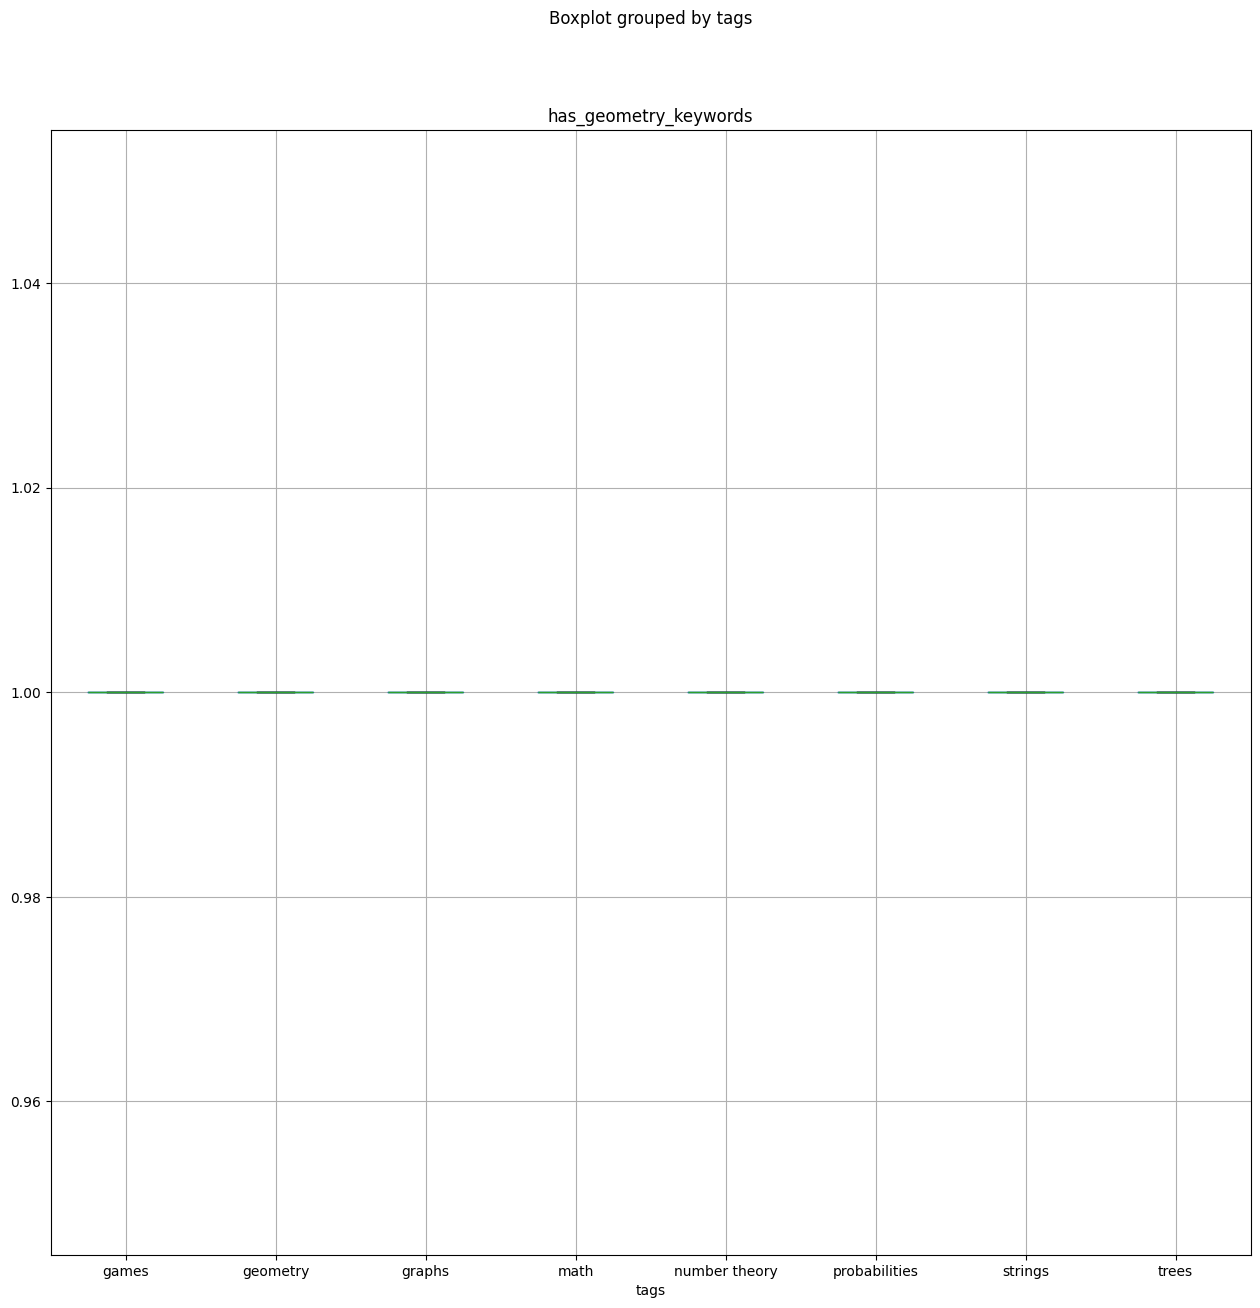

In [11]:
print(dataframe.columns)
df_exploded = dataframe.explode(column="tags")
df_exploded.boxplot(by="tags",column="has_geometry_keywords",figsize=(15,15))

c:\Users\francois.le-guernic\Desktop\CodeClassification\utils\training_utils.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(confusions.index, rotation=45, ha='right')
c:\Users\francois.le-guernic\Desktop\CodeClassification\utils\training_utils.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(confusions.index, rotation=45, ha='right')
c:\Users\francois.le-guernic\Desktop\CodeClassification\utils\training_utils.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(confusions.index, rotation=45, ha='right')
c:\Users\francois.le-guernic\Desktop\CodeClassification\utils\training_utils.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks,

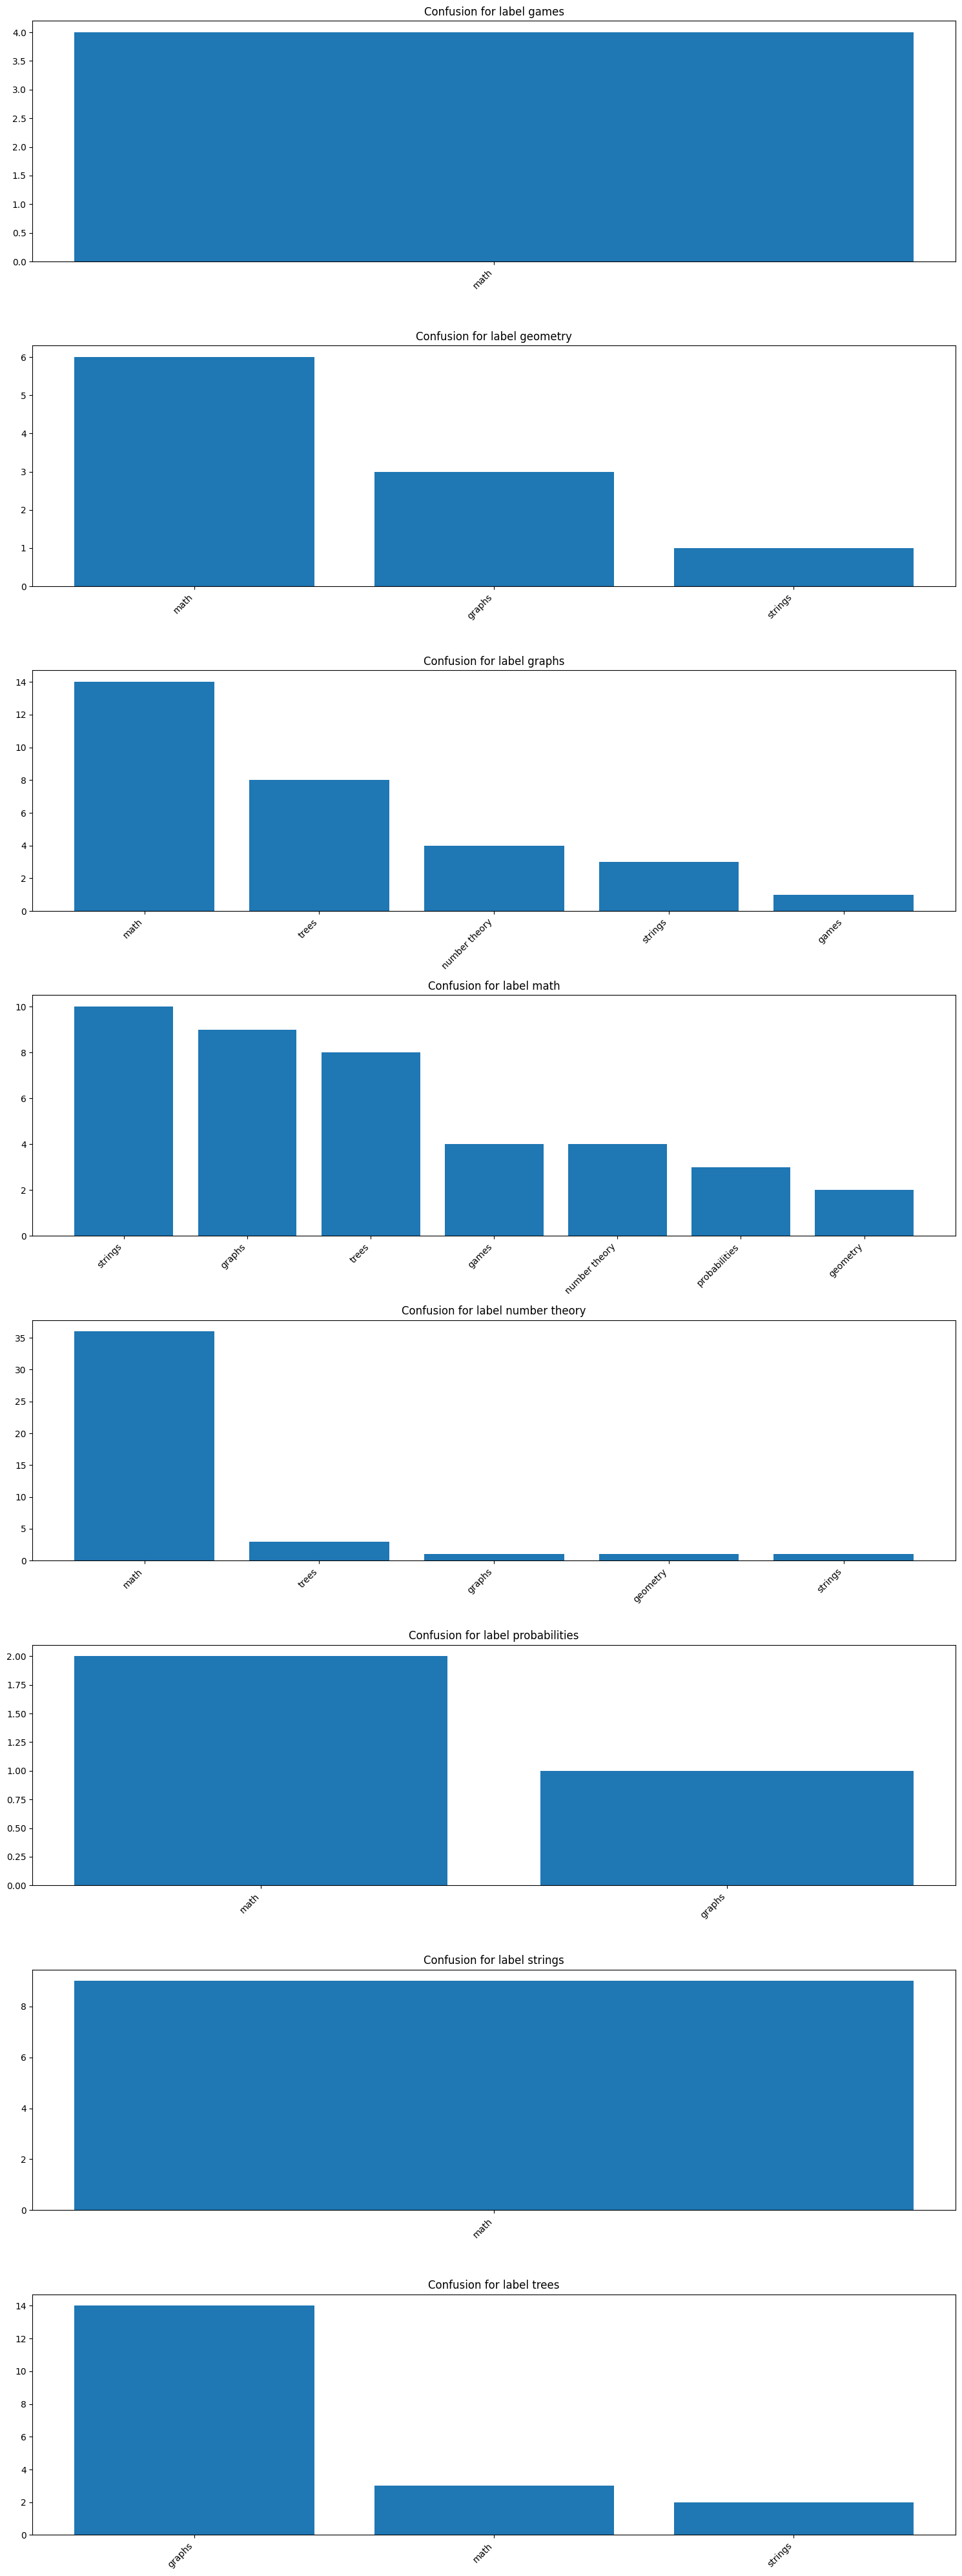

In [21]:
bar_plot_confusion(analyze_tag_confusions(y_test,y_pred,mlb.classes_))

In [21]:
nt = get_rows_containing_label("number theory",dataframe)
math = get_rows_containing_label("math",dataframe)


frequent_nt  = set(map(lambda x : x[0] ,get_most_frequent_words(nt,200,"source_code")))
frequent_math = set(map(lambda x : x[0], get_most_frequent_words(math,200,"source_code")))
vocab  = set(map(lambda x : x ,tfidf.vocabulary_))
#print(vocab)
#print(len(vocab))


print(frequent_nt.difference(frequent_math).difference(tfidf2.vocabulary_))

feature_names  =tfidf2.get_feature_names_out()
Y = dataframe["tags"]
number_theory_idx = [i for i, y in enumerate(Y) if 'number theory' in y]
math_idx = [i for i, y in enumerate(Y) if 'math' in y]

X_number_theory = X2[number_theory_idx]
X_math = X2[math_idx]

import numpy as np
import pandas as pd 

mean_tfidf_nt = np.asarray(X_number_theory.mean(axis=0)).flatten()
mean_tfidf_math = np.asarray(X_math.mean(axis=0)).flatten()


df = pd.DataFrame({
    'term': feature_names,
    'number_theory': mean_tfidf_nt,
    'math': mean_tfidf_math
})

df['diff'] = df['number_theory'] - df['math']
df.sort_values('diff', ascending=False).head(20)





{'subset', 'greatest', 'operatorname', 'divisors', 'difference', 'form', 'conditions', 'leading', 'b_', 'replace', 'lcm', 'color', 'a1', 'obtained', 'b_1', 'infinite', 'beautiful', 'decimal', 'pieces', 'product', 'interesting', 'denote', 'remainder', 'considered', 'ball', 'exist', 'cards', 'u', 'version', 'consider', 'colored', 'vertex', 'white', 'arbitrary', 'prime', 'a2'}


,term,number_theory,math,diff
93,gcd,0.069822,0.021036,0.048786
210,return,0.088325,0.061114,0.027211
63,def,0.075247,0.055615,0.019633
149,math,0.058213,0.039295,0.018918
51,cnt,0.035333,0.020351,0.014982
98,import,0.064804,0.051027,0.013777
214,return return,0.029041,0.015860,0.013181
73,dp,0.028231,0.015262,0.012968
157,mod,0.043621,0.030972,0.012650
0,10,0.044688,0.032127,0.012561


In [33]:
import ast
import re
def count_functions(code_str):
       return  len(re.findall(r'^\s*def\s+\w+\s*\(', code_str, flags=re.MULTILINE))
    
def count_arithmetic_operations(code):
    return len(re.findall(r'(?<!\w)(\+|\-|\*\*|\*|//|/|%)', code))
       
def len_code_words(code):
      return len(code.split(" "))
dataframe["func_def"] = dataframe["source_code"].apply(count_functions)
dataframe["count_arithmetic_op"] = dataframe["source_code"].apply(count_arithmetic_operations)
dataframe["lenc_code_words"] = dataframe["source_code"].apply(len_code_words)
dataframe["ratio"] = dataframe["count_arithmetic_op"]/ dataframe["lenc_code_words"]

<Axes: title={'center': 'ratio'}, xlabel='tags'>

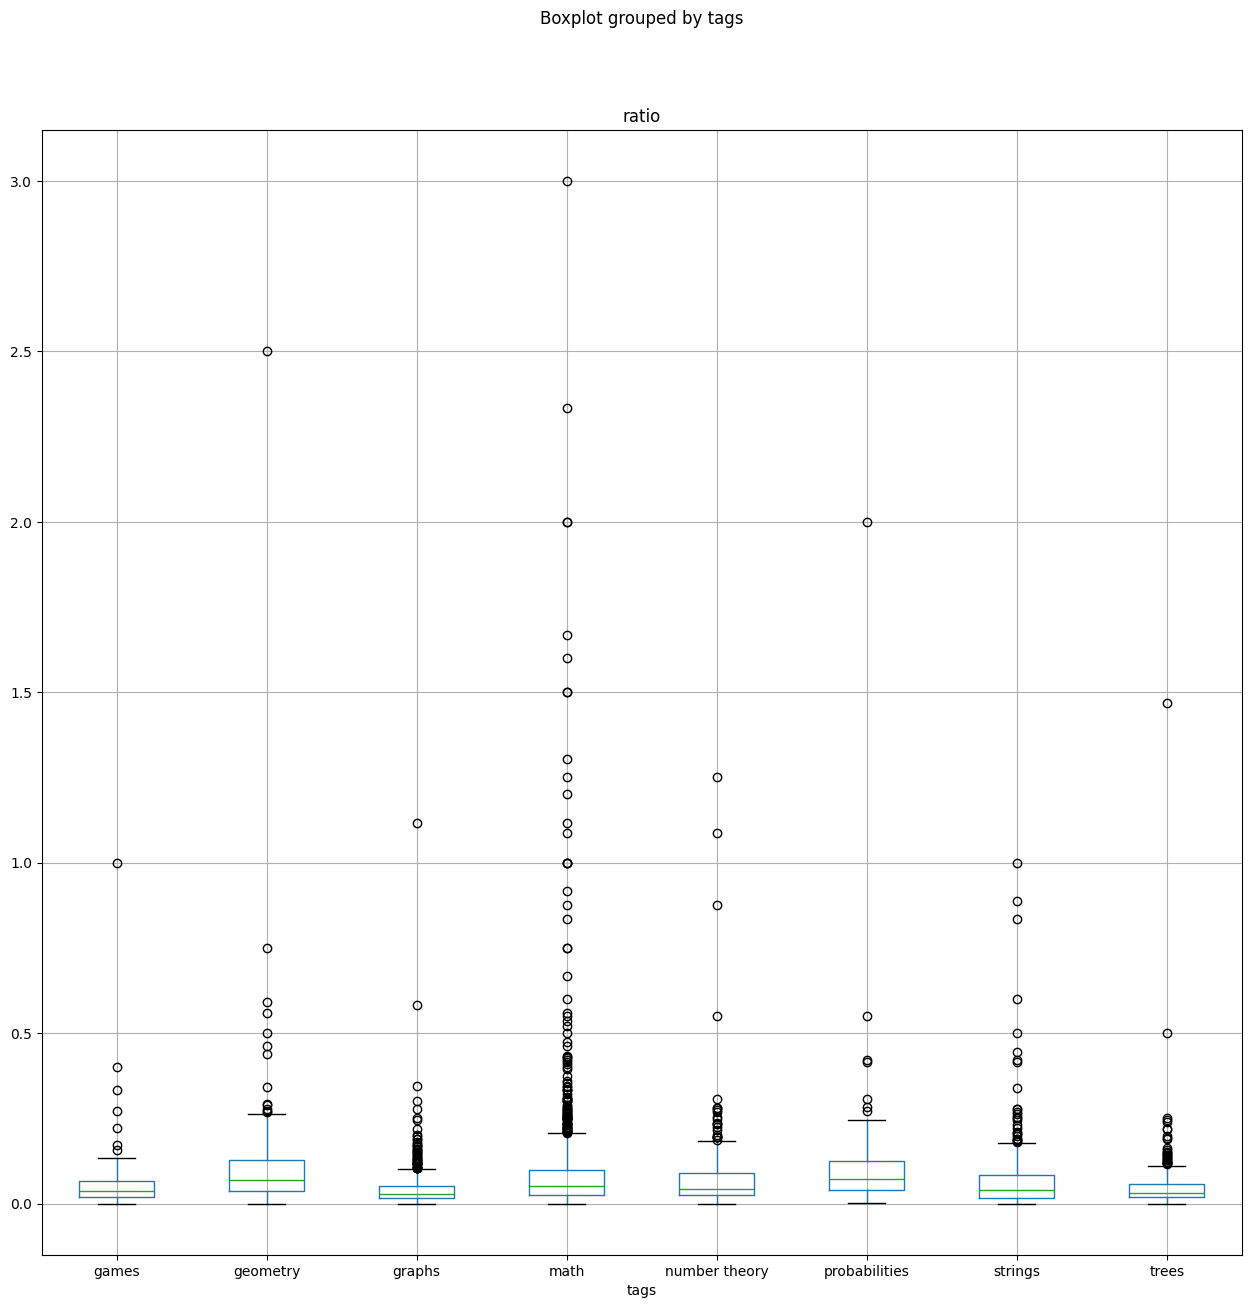

In [34]:

df_exploded = dataframe.explode(column="tags")
df_exploded.boxplot(by="tags",column="ratio",figsize=(15,15))

In [6]:
for w in tfidf.vocabulary_:
    print(w)

numbers
dots
integer
written
board
operation
erase
write
frac
rounded
instead
perform
given
times
make
resulting
number
left
small
possible
example
following
course
action
optimal
choose
new
contains
easy
operations
goal
minimize
operation times
small possible
example following
positive
integers
a_1
a_2
a_n
value
divide
elements
equal
12
transformed
need
minimal
moves
array
odd
element
divisible
positive integers
integers a_1
a_1 a_2
a_2 dots
dots a_n
elements equal
minimal number
number moves
integers a_1 a_2
a_1 a_2 dots
a_2 dots a_n
undirected
graph
consisting
vertices
vertex
a_i
initially
edges
add
pay
cost
adding
edge
a_x
coins
special
denoted
means
connecting
don
use
pair
connect
minimum
spend
connected
recall
using
given undirected
undirected graph
graph consisting
consisting vertices
number written
vertex number
edges graph
add edge
pair vertices
minimum number
number coins
vertex vertex
undirected graph consisting
graph consisting vertices
strictly
greater
zero
called
round
fo